In [3]:
#SOURCE: https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89/notebook

In [5]:
#imports
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [6]:
image_dir = Path('../classifier/Fish_Dataset/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [7]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,..\classifier\Fish_Dataset\Trout\Trout\00614.png,Trout
1,..\classifier\Fish_Dataset\Red Mullet\Red Mull...,Red Mullet
2,..\classifier\Fish_Dataset\Striped Red Mullet\...,Striped Red Mullet


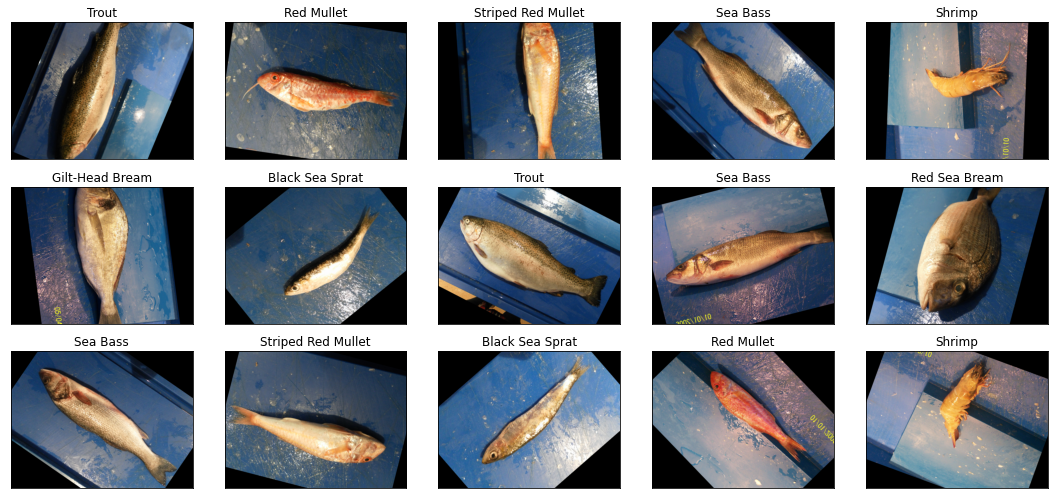

In [8]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [12]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 58s 265ms/step - loss: 0.1704 - accuracy: 0.9551 - val_loss: 0.0226 - val_accuracy: 0.9932
Epoch 2/50
203/203 [==============================] - 50s 249ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 3/50
203/203 [==============================] - 51s 252ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0099 - val_accuracy: 0.9963


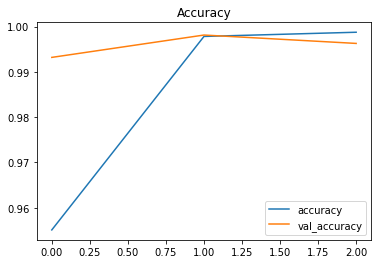

In [14]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

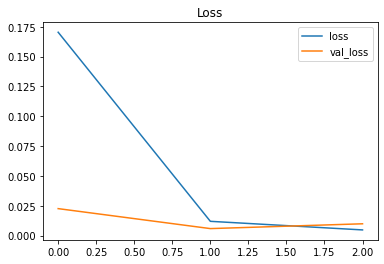

In [15]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00466
Test Accuracy: 99.89%


In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 [==============================] - 6s 202ms/step
The first 5 predictions: ['Sea Bass', 'Red Sea Bream', 'Gilt-Head Bream', 'Striped Red Mullet', 'Gilt-Head Bream']


In [18]:
# Saving the model for later usage

model.save('../classifier/')

INFO:tensorflow:Assets written to: ../classifier/assets


INFO:tensorflow:Assets written to: ../classifier/assets


In [19]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        96
   Gilt-Head Bream       1.00      1.00      1.00        97
   Hourse Mackerel       1.00      0.99      0.99        97
        Red Mullet       1.00      1.00      1.00        99
     Red Sea Bream       1.00      1.00      1.00       108
          Sea Bass       1.00      1.00      1.00       101
            Shrimp       1.00      1.00      1.00        89
Striped Red Mullet       0.99      1.00      1.00       107
             Trout       1.00      1.00      1.00       106

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



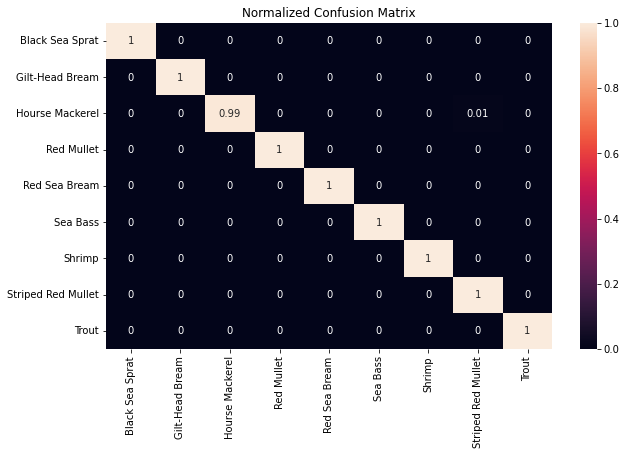

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

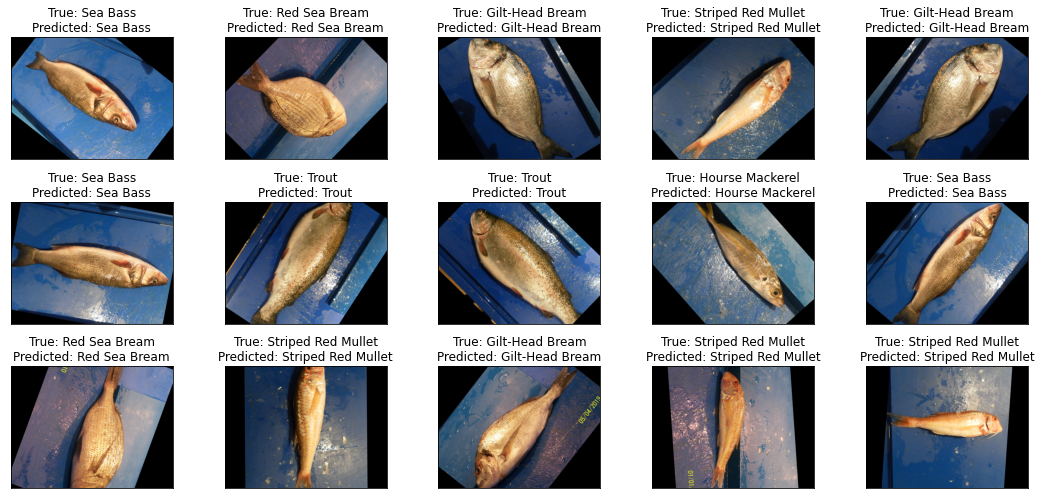

In [21]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [32]:
# Loading in some different test data downloaded from Google

image_dir = Path('../classifier/Test_images/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
testi_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
testi_df = testi_df[testi_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [33]:
# Shuffle the DataFrame and reset index
testi_df = testi_df.sample(frac=1).reset_index(drop = True)

# Show the result
testi_df.head(3)

,Filepath,Label
0,..\classifier\Test_images\Sarki\2.png,Sarki
1,..\classifier\Test_images\Kuha\2.png,Kuha
2,..\classifier\Test_images\Hauki\1.png,Hauki


In [41]:
testi_kuvat = test_generator.flow_from_dataframe(
    dataframe=testi_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 13 validated image filenames belonging to 4 classes.


In [65]:
# Predict the label of the test_images
pred = model.predict(testi_kuvat)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
for i in range(10):
    print(f"True: {testi_df.Label.iloc[i]}\nPredicted: {pred[i]}")

1/1 [==============================] - 0s 170ms/step
True: Sarki
Predicted: Sea Bass
True: Kuha
Predicted: Sea Bass
True: Hauki
Predicted: Trout
True: Sarki
Predicted: Trout
True: Hauki
Predicted: Sea Bass
True: Ahven
Predicted: Sea Bass
True: Ahven
Predicted: Trout
True: Ahven
Predicted: Trout
True: Ahven
Predicted: Hourse Mackerel
True: Ahven
Predicted: Sea Bass
